# Import Modules & Read Data

In [30]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pltp
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from sklearn.metrics import accuracy_score
import sklearn
import matplotlib.animation as FuncAnimation


#ion('display.max_rows', 1000)
# pd.options.display.float_format = '{:,.0f}'.format
%matplotlib inline

# Define a date parser to pass to read_csv
d = lambda x: pd.datetime.strptime(x, '%d-%b-%y')

# Load the data
df = pd.read_csv('./data/sentinel-5P/aug_21_filtered.csv', index_col=False, parse_dates = ['time_utc'])

#Pandas profiling
# profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# profile.to_file("your_report.html")

#Generic Info
print("SIZE:", df.shape)
print("COLUMNS:", df.columns)
# print("SECTORS:", df['Sectors (IPCC)'].unique())
df.head()

# np.where(df_dropped['Qplume (kg/hr): Plume emissions'] == max(df_dropped['Qplume (kg/hr): Plume emissions']))

SIZE: (98727, 8)
COLUMNS: Index(['Unnamed: 0', 'time_utc', 'lat', 'lon', 'qa_val',
       'methane_mixing_ratio', 'methane_mixing_ratio_precision',
       'methane_mixing_ratio_bias_corrected'],
      dtype='object')


,Unnamed: 0,time_utc,lat,lon,qa_val,methane_mixing_ratio,methane_mixing_ratio_precision,methane_mixing_ratio_bias_corrected
0,0,2021-08-01 19:57:42.668000+00:00,32.866806,-114.359250,0.4,1858.0217,1.434432,1860.8737
1,1,2021-08-01 19:57:43.508000+00:00,32.799152,-114.617550,0.4,1869.6572,1.434827,1873.1146
2,2,2021-08-01 19:57:43.508000+00:00,32.914066,-114.380090,0.4,1850.1168,1.449401,1853.2874
3,3,2021-08-01 19:57:44.348000+00:00,32.846360,-114.638510,0.4,1876.0233,1.410911,1878.4884
4,4,2021-08-01 19:57:47.708000+00:00,33.035030,-114.722824,0.4,1852.6785,1.527326,1857.2365


In [31]:
#Create list of unique dates
df['date_utc']=df.time_utc.dt.date
dates=df.date_utc.unique()

#Drop unnecessary columns
df.drop('time_utc', axis=1, inplace=True)
df.drop('qa_val', axis=1, inplace=True)
df.drop('methane_mixing_ratio', axis=1, inplace=True)
df.drop('methane_mixing_ratio_precision', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,lat,lon,methane_mixing_ratio_bias_corrected,date_utc
0,32.866806,-114.359250,1860.8737,2021-08-01
1,32.799152,-114.617550,1873.1146,2021-08-01
2,32.914066,-114.380090,1853.2874,2021-08-01
3,32.846360,-114.638510,1878.4884,2021-08-01
4,33.035030,-114.722824,1857.2365,2021-08-01
...,...,...,...,...
98722,41.969150,-122.337555,1872.0219,2021-08-31
98723,41.314465,-124.118160,1823.5817,2021-08-31
98724,41.361683,-124.142240,1796.3965,2021-08-31
98725,41.854527,-124.197470,1893.3547,2021-08-31


In [36]:
# Aggregate dataset by 0.1 lat/lon
df['lat'] = df.lat.round(1)
df['lon'] = df.lon.round(1)
df=df.groupby(['lat','lon', 'date_utc']).mean().reset_index(['lat','lon', 'date_utc'])
df

,lat,lon,date_utc,methane_mixing_ratio_bias_corrected
0,32.8,-118.5,2021-08-05,1815.4683
1,32.8,-118.4,2021-08-04,1837.5812
2,32.8,-118.3,2021-08-30,1855.1196
3,32.8,-117.3,2021-08-02,1842.4240
4,32.8,-117.3,2021-08-04,1831.7054
...,...,...,...,...
61693,42.0,-114.0,2021-08-25,1865.0570
61694,42.0,-114.0,2021-08-27,1886.4285
61695,42.0,-114.0,2021-08-29,1845.3790
61696,42.0,-114.0,2021-08-30,1860.5697


# Subset Dataset and Bin Data

In [37]:
#Create list of dataframe and train data, one for each date
df_dates=dict()
train_data_list=[]

for i in range(len(dates)-1):
    df_date = df[df.date_utc == dates[i+1]]
    
    #Bin by methane value and store binned datasets in dictionary
    def create_bins_labels(df_date):
        a=df.methane_mixing_ratio_bias_corrected.describe()
        bins=[0, a[4], a[5],a[6],a[7]]
        labels = [i for i in range(len(bins)-1)]
        return bins, labels
    df_date['binned'] = pd.cut(df_date['methane_mixing_ratio_bias_corrected'], create_bins_labels(df_date)[0], labels=create_bins_labels(df_date)[1])
    df_date_1=df_date[df_date.binned==0]
    df_date_2=df_date[df_date.binned==1]
    df_date_3=df_date[df_date.binned==2]
    df_date_4=df_date[df_date.binned==3]
    df_dates[i]=[df_date_1,df_date_2,df_date_3,df_date_4]
    
    #For kMeans and GMM Clustering
    train_data = []
    for lat,lon in zip(df_date.lat, df_date.lon):
        train_data.append([lat,lon])
    train_data = np.array(train_data)
    #print(train_data[0:5])
    train_data_list.append(train_data)
    
df_dates[0][0].head(5)

<ipython-input-37-e90c86287ea0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date['binned'] = pd.cut(df_date['methane_mixing_ratio_bias_corrected'], create_bins_labels(df_date)[0], labels=create_bins_labels(df_date)[1])


,lat,lon,date_utc,methane_mixing_ratio_bias_corrected,binned
3,32.8,-117.3,2021-08-02,1842.4240,0
341,32.8,-113.9,2021-08-02,1859.5647,0
365,32.9,-118.4,2021-08-02,1783.9928,0
418,32.9,-116.2,2021-08-02,1856.6382,0
841,33.0,-116.1,2021-08-02,1859.3473,0


# Simple Plot

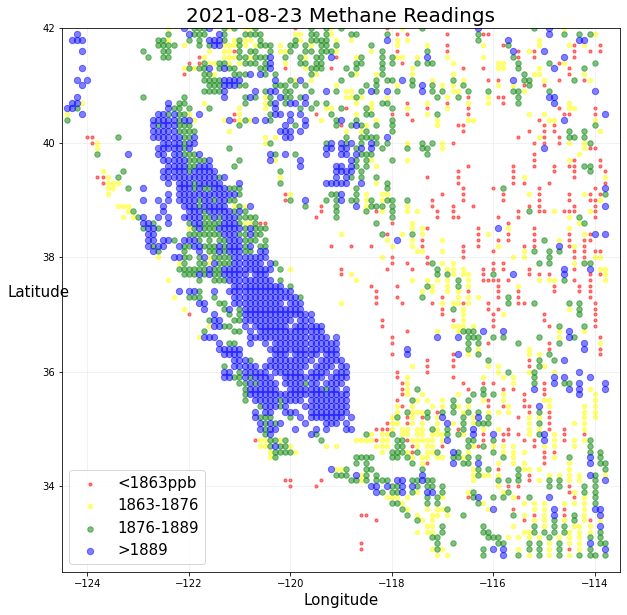

In [46]:
#Plotting 1 plot
%matplotlib inline

i=20
fig1=plt.figure(figsize=(10,10))
plt.ylim([32.5,42])
plt.xlim([-124.5,-113.5])

# plt.colorbar(fig1)
day=str(df_dates[i][0].date_utc.iloc[0])
fig1=plt.title(day+' Methane Readings', fontsize=20)
fig1=plt.xlabel('Longitude', fontsize=15)
fig1=plt.ylabel('Latitude', rotation=0, fontsize=15)
fig1=plt.grid(True, alpha=0.2)

# fig1=plt.scatter(df_date.lat, df_date.lon, color='red', alpha=0.5, s=df_date.methane_mixing_ratio_bias_corrected/1000)
# fig1=plt.scatter(df_date.lat, df_date.lon, c=df_date.methane_mixing_ratio_bias_corrected, cmap='rainbow', alpha=0.50, vmin=1850,vmax=1950)
fig1=plt.scatter(df_dates[i][0].lon, df_dates[i][0].lat, color='red', alpha=0.5, s=10)
fig1=plt.scatter(df_dates[i][1].lon, df_dates[i][1].lat, color='yellow', alpha=0.5, s=20)
fig1=plt.scatter(df_dates[i][2].lon, df_dates[i][2].lat, color='green', alpha=0.5, s=30)
fig1=plt.scatter(df_dates[i][3].lon, df_dates[i][3].lat, color='blue', alpha=0.5, s=40)
plt.legend(['<1863ppb','1863-1876', '1876-1889', '>1889'], fontsize=15)#, loc='lower left')


In [47]:
#Animation Plot 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib notebook

fig1, ax= plt.subplots(figsize=(10,10))


def init():
    return

def animate(i):

    # fig1=plt.scatter(df_date.lat, df_date.lon, color='red', alpha=0.5, s=df_date.methane_mixing_ratio_bias_corrected/1000)
    # fig1=plt.scatter(df_date.lat, df_date.lon, c=df_date.methane_mixing_ratio_bias_corrected, cmap='rainbow', alpha=0.50, vmin=1850,vmax=1950)
    # plt.colorbar(fig1)
    ax.clear()
    day=str(df_dates[i][0].date_utc.iloc[0])
    fig1=plt.title(day+' Methane Readings', fontsize=20)
    fig1=plt.xlabel('Longitude', fontsize=15)
    fig1=plt.ylabel('Latitude', rotation=0, fontsize=15)
    fig1=plt.grid(True, alpha=0.2)
    plt.ylim([32.5,42])
    plt.xlim([-124.5,-113.5])
    fig1=plt.scatter(df_dates[i][0].lon, df_dates[i][0].lat, color='red', alpha=0.5, s=5)
    fig1=plt.scatter(df_dates[i][1].lon, df_dates[i][1].lat, color='yellow', alpha=0.5, s=10)
    fig1=plt.scatter(df_dates[i][2].lon, df_dates[i][2].lat, color='green', alpha=0.5, s=15)
    fig1=plt.scatter(df_dates[i][3].lon, df_dates[i][3].lat, color='blue', alpha=0.5, s=20)
    plt.legend(['<1863ppb','1863-1876', '1876-1889', '>1889'], loc='lower left', fontsize=20)


anim = animation.FuncAnimation(fig1, animate, frames=29 , interval=500, init_func=init, blit=True)
anim.save('animation_simple_scatter.gif', writer='pillow')    #saves the animation to a .gif file
#Update 10.20.2020, writer='ffmpeg' does not work, switched to 'pillow'

plt.show()    #looks better when you save the animation

<IPython.core.display.Javascript object>

# KMeans Clustering 1 (color coded by clusters)

<ipython-input-104-ca5455f916cb>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fig = plt.scatter(train_data_list[0][:,1],train_data_list[0][:,0], c=labels.astype(np.float),marker='.', alpha=1,s=10)


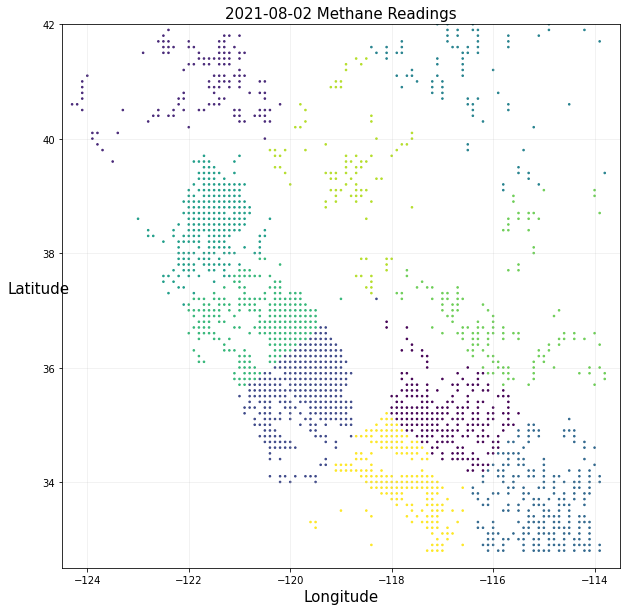

In [104]:
#Run KMeans
i=0
C=10
km = KMeans(n_clusters=C)
clstrs=km.fit(train_data_list[i])
labels = km.labels_

#Plotting the 2-d PCA data along with the cluster centers
%matplotlib inline
fig1, ax= plt.subplots(figsize=(10,10))
plt.ylim([32.5,42])
plt.xlim([-124.5,-113.5])
day=str(df_dates[i][0].date_utc.iloc[0])
fig1=plt.title(day+' Methane Readings', fontsize=15)
fig1=plt.xlabel('Longitude', fontsize=15)
fig1=plt.ylabel('Latitude', rotation=0, fontsize=15)
fig = plt.scatter(train_data_list[0][:,1],train_data_list[0][:,0], c=labels.astype(np.float),marker='.', alpha=1,s=10)
fig1=plt.grid(True, alpha=0.2)    

In [109]:
#Animated
#Animation Plot 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib notebook

fig1, ax= plt.subplots(figsize=(10,10))

def animate_kmeans(i):
    ax.clear()
    
    #Run KMeans
    C=10
    km = KMeans(n_clusters=C)
    clstrs=km.fit(train_data_list[i])
    labels = km.labels_

    #Plot
    plt.ylim([32.5,42])
    plt.xlim([-124.5,-113.5])
    day=str(df_dates[i][0].date_utc.iloc[0])
    fig1=plt.title(str(C) + " Kmeans Clusters on "+day, fontsize=20)
    fig1=plt.xlabel('Longitude', fontsize=15)
    fig1=plt.ylabel('Latitude', rotation=0, fontsize=15)
    fig = plt.scatter(train_data_list[i][:,1],train_data_list[i][:,0], c=labels.astype(np.float),marker='.', alpha=1,s=10)
    fig1=plt.grid(True, alpha=0.2)   

anim = animation.FuncAnimation(fig1, animate_kmeans,frames=29 , interval=500, blit=False)
anim.save('animation_kmeans.gif', writer='pillow')    #saves the animation to a .gif file
#Update 10.20.2020, writer='ffmpeg' does not work, switched to 'pillow'

plt.show()    #looks better when you save the animation

<IPython.core.display.Javascript object>

<ipython-input-109-9cc2b0a3bfb5>:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fig = plt.scatter(train_data_list[i][:,1],train_data_list[i][:,0], c=labels.astype(np.float),marker='.', alpha=1,s=10)
<ipython-input-109-9cc2b0a3bfb5>:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fig = plt.scatter(train_data_list[i][:,1],train_data_li

# KMeans Clustering 2 (circle of cluster regions)

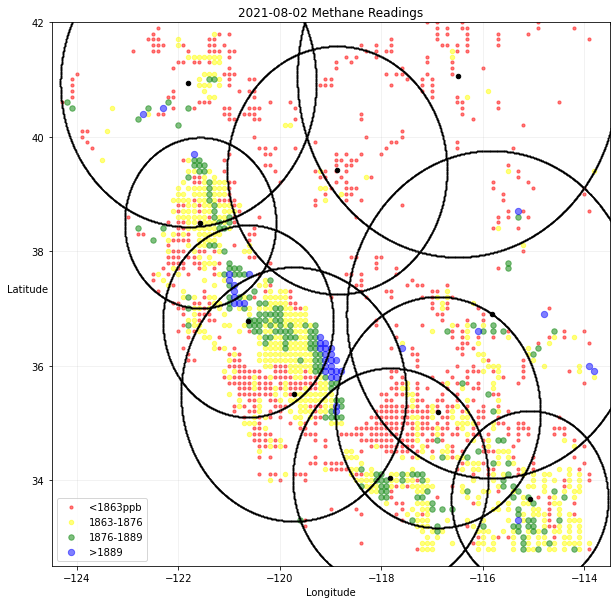

In [48]:
#Run KMeans
i=0
C=10
km = KMeans(n_clusters=C)
clstrs=km.fit(train_data_list[i])
# print(clstrs)
# print(clstrs.cluster_centers_[0:5])

#Plotting the 2-d PCA data along with the cluster centers
%matplotlib inline

fig1, ax= plt.subplots(figsize=(10,10))
plt.ylim([32.5,42])
plt.xlim([-124.5,-113.5])
day=str(df_dates[i][0].date_utc.iloc[0])
fig1=plt.title(day+' Methane Readings')
fig1=plt.xlabel('Longitude')
fig1=plt.ylabel('Latitude', rotation=0)
fig1=plt.scatter(df_dates[i][0].lon, df_dates[i][0].lat, color='red', alpha=0.5, s=10)
fig1=plt.scatter(df_dates[i][1].lon, df_dates[i][1].lat, color='yellow', alpha=0.5, s=20)
fig1=plt.scatter(df_dates[i][2].lon, df_dates[i][2].lat, color='green', alpha=0.5, s=30)
fig1=plt.scatter(df_dates[i][3].lon, df_dates[i][3].lat, color='blue', alpha=0.5, s=40)
fig1=plt.scatter(clstrs.cluster_centers_[:,1], clstrs.cluster_centers_[:,0], color='black',s=20) 
fig1=plt.grid(True, alpha=0.2)
plt.legend(['<1863ppb','1863-1876', '1876-1889', '>1889'], loc='lower left')
    
#Finding Most distant example in cluster and plotting a circle based on this point    
for j in range(C):
    c=train_data_list[i][np.where(clstrs.labels_==j)]     #finds all points in a cluster
    lnorm=[]                                 #create a list of lnorms of each point in the cluster
    for k in range(len(c)):
        lnorm.append(np.linalg.norm(c[k]-clstrs.cluster_centers_[j]))
    maximum=np.where(lnorm==max(lnorm))      #find index for the point with maximum lnorm 

    #Plotting circles by creating 100 points around a centroid with radius based on furthest point    
    a=c[maximum][0][0]-clstrs.cluster_centers_[j][0]               #Find radius with r=sqrt(a^2+b^2)
    b=c[maximum][0][1]-clstrs.cluster_centers_[j][1]
    r=np.sqrt(a**2+b**2)
    pts = int(r*1000)                                               #generate points in degrees for a circle
    theta=np.linspace(0,2*np.pi,pts)                               #generate points in degrees for a circle
    x1=r*np.cos(theta)+clstrs.cluster_centers_[j][1]         
    x2=r*np.sin(theta)+clstrs.cluster_centers_[j][0]
    fig1=plt.scatter(x1,x2, color='black',marker='.', alpha=1,s=1)   

In [38]:
#Animated
#Animation Plot 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib notebook

fig1, ax= plt.subplots(figsize=(10,10))
plt.ylim([32.5,42])
plt.xlim([-124.5,-113.5])

def animate_kmeans(i):
    ax.clear()
    
    #Run KMeans
    clusters=50
    km = KMeans(n_clusters=clusters)
    clstrs=km.fit(train_data_list[i])
    # print(clstrs)
    #print(clstrs.cluster_centers_[0:5])

    #Plot
    day=str(df_dates[i][0].date_utc.iloc[0])
    fig1=plt.title(day+' Methane Readings')
    fig1=plt.xlabel('Latitude')
    fig1=plt.ylabel('Longitude', rotation=0)
    fig1=plt.scatter(df_dates[i][0].lon, df_dates[i][0].lat, color='red', alpha=0.5, s=10)
    fig1=plt.scatter(df_dates[i][1].lon, df_dates[i][1].lat, color='yellow', alpha=0.5, s=20)
    fig1=plt.scatter(df_dates[i][2].lon, df_dates[i][2].lat, color='green', alpha=0.5, s=30)
    fig1=plt.scatter(df_dates[i][3].lon, df_dates[i][3].lat, color='blue', alpha=0.5, s=40)
    fig1=plt.scatter(clstrs.cluster_centers_[:,1], clstrs.cluster_centers_[:,0], color='black',s=20) 
    fig1=plt.grid(True, alpha=0.2)
    plt.legend(['<1863ppb','1863-1876', '1876-1889', '>1889'], loc='lower left')

    #Finding Most distant example in cluster and plotting a circle based on this point    
    for j in range(clusters):
        c=train_data_list[i][np.where(clstrs.labels_==j)]     #finds all points in a cluster
        lnorm=[]                                 #create a list of lnorms of each point in the cluster
        for l in range(len(c)):
            lnorm.append(np.linalg.norm(c[l]-clstrs.cluster_centers_[j]))
        maximum=np.where(lnorm==max(lnorm))      #find index for the point with maximum lnorm 

        #Plotting circles by creating 100 points around a centroid with radius based on furthest point    
        a=c[maximum][0][0]-clstrs.cluster_centers_[j][0]               #Find radius with r=sqrt(a^2+b^2)
        b=c[maximum][0][1]-clstrs.cluster_centers_[j][1]
        r=np.sqrt(a**2+b**2)
        pts = int(r*1000)                                               #generate points in degrees for a circle
        theta=np.linspace(0,2*np.pi,pts)                               #generate points in degrees for a circle
        x1=r*np.cos(theta)+clstrs.cluster_centers_[j][1]         
        x2=r*np.sin(theta)+clstrs.cluster_centers_[j][0]
        fig1=plt.scatter(x1,x2, color='black',marker='.', alpha=1,s=1)   

anim = animation.FuncAnimation(fig1, animate_kmeans,frames=29 , interval=500, blit=False)
anim.save('animation_kmeans.gif', writer='pillow')    #saves the animation to a .gif file
#Update 10.20.2020, writer='ffmpeg' does not work, switched to 'pillow'

plt.show()    #looks better when you save the animation

<IPython.core.display.Javascript object>

# GMM Clustering

<ipython-input-110-63195ae35a05>:30: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  CB = fig.colorbar(CS, shrink=0.8, extend='both', ax=axs[n-1,counter])
<ipython-input-110-63195ae35a05>:30: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  CB = fig.colorbar(CS, shrink=0.8, extend='both', ax=axs[n-1,counter])
<ipython-input-110-63195ae35a05>:30: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  CB = fig.colorbar(CS, shrink=0.8, extend='both', ax=axs[n-1,counter])
<ipython-input-110-63195ae35a05>:30: MatplotlibDeprecationWarning: The 'extend' parameter t

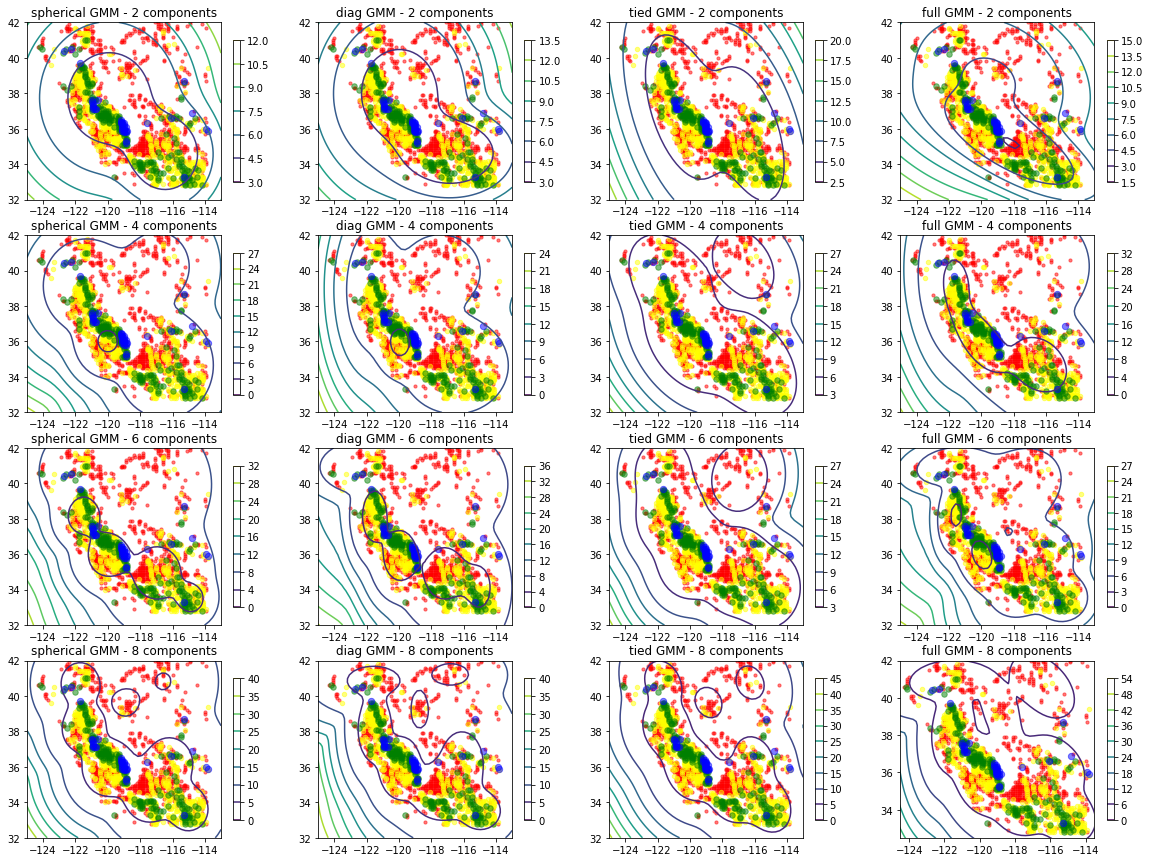

In [110]:
# 1st = Creating a meshgrid to plot the GMM with PCA in
x = np.linspace(32, 42)   
y = np.linspace(-125, -113)
Xx, Yy = np.meshgrid(x, y)
XX = np.array([Xx.ravel(), Yy.ravel()]).T

#Initiating different gaussian models and different number of components
ctype=['spherical','diag','tied','full']
n_components=[1,2,3,4]
n_gmm_components=[2,4,6,8]


%matplotlib inline

# Initiating a figure/figure size with subplots 
fig, axs = plt.subplots(len(n_components),4, figsize=(20,15))
plt.ylim([32.5,42])
plt.xlim([-124.5,-113.5])

# Loop for each different Gaussian model and plot the GMM score_samples within the meshgrid
# Also scatterplot the PCA 2-d data
for n,gn in zip(n_components,n_gmm_components):
    counter=0
    for c in ctype:
        GMM = GaussianMixture(n_components=gn, covariance_type=c, random_state=12345)
        clstrs=GMM.fit(train_data_list[0])
        Zz = -clstrs.score_samples(XX)   #use negative because log of probability is negative so I wanted to flip the sign
        Zz = Zz.reshape(Xx.shape)
        CS = axs[n-1,counter].contour(Yy, Xx, Zz)  
        CB = fig.colorbar(CS, shrink=0.8, extend='both', ax=axs[n-1,counter])
        axs[n-1,counter].scatter(df_dates[0][0].lon, df_dates[0][0].lat, color='red', alpha=0.5, s=10)
        axs[n-1,counter].scatter(df_dates[0][1].lon, df_dates[0][1].lat, color='yellow', alpha=0.5, s=20)
        axs[n-1,counter].scatter(df_dates[0][2].lon, df_dates[0][2].lat, color='green', alpha=0.5, s=30)
        axs[n-1,counter].scatter(df_dates[0][3].lon, df_dates[0][3].lat, color='blue', alpha=0.5, s=40)
        axs[n-1,counter].set_title("%s GMM - %s components" %(c,gn))      
        
        counter+=1

In [113]:
#Animated, select only 1 of the 16 plots to animate
#Animation Plot 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib notebook


# 1st = Creating a meshgrid to plot the GMM with PCA in
x = np.linspace(32, 42)   
y = np.linspace(-125, -113)
Xx, Yy = np.meshgrid(x, y)
XX = np.array([Xx.ravel(), Yy.ravel()]).T

#Initiating different gaussian models and different number of components
ctype=['spherical']
n_gmm_components=10


# Initiating a figure/figure size with subplots 
fig1, ax = plt.subplots(figsize=(10,10))

def animate_gmm(i):
    ax.clear()
    
    # Loop for each different Gaussian model and plot the GMM score_samples within the meshgrid
    # Also scatterplot the PCA 2-d data

    GMM = GaussianMixture(n_components=n_gmm_components, covariance_type=ctype[0], random_state=12345)
    clstrs=GMM.fit(train_data_list[i])
    Zz = -clstrs.score_samples(XX)   #use negative because log of probability is negative so I wanted to flip the sign
    Zz = Zz.reshape(Xx.shape)
    CS = ax.contour(Yy, Xx, Zz)  
    # CB = fig1.colorbar(CS, shrink=0.8, extend='both', ax=axs[n-1,counter])
    ax.scatter(df_dates[i][0].lon, df_dates[i][0].lat, color='red', alpha=0.5, s=10)
    ax.scatter(df_dates[i][1].lon, df_dates[i][1].lat, color='yellow', alpha=0.5, s=20)
    ax.scatter(df_dates[i][2].lon, df_dates[i][2].lat, color='green', alpha=0.5, s=30)
    ax.scatter(df_dates[i][3].lon, df_dates[i][3].lat, color='blue', alpha=0.5, s=40)
    day=str(df_dates[i][0].date_utc.iloc[0])
   
    ax.set_title("%s - %s GMM - %s components" %(day, ctype[0],n_gmm_components), fontsize=20)           


anim = animation.FuncAnimation(fig1, animate_gmm,frames=29 , interval=500, blit=False)
anim.save('animation_gmm.gif', writer='pillow')    #saves the animation to a .gif file
#Update 10.20.2020, writer='ffmpeg' does not work, switched to 'pillow'

plt.show()    #looks better when you save the animation

<IPython.core.display.Javascript object>